In [2]:
''' 
Development Juptyer Notebooks for The Benchmark Calculation Overtime . 
''' 

from abc import abstractmethod, ABC 
import pandas as pd 
from typing import Iterable, List, Optional
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt


In [3]:
'''  
pulling cleaned data into the notebook 
'''
df = pd.read_csv("bloomberg_data_cleaned.csv")

#set date to datetime object 
df["date"] = pd.to_datetime(df["date"])
df.set_index(["date","ticker"],inplace= True)
pd.set_option('display.float_format', '{:,.4f}'.format)
df.head()

market_cap          volume  price_to_book  \
date       ticker                                                 
2022-01-03 A         47,257.0847    554,098.0000         8.7692   
           AA        11,293.5460  1,033,749.0000         2.3785   
           AAL       12,140.8973  8,786,970.0000            NaN   
           AAON       4,106.6876     83,790.0000         8.8262   
           AAPL   2,986,128.3180 20,242,137.0000        41.3474   

                   price_to_sales  pe_ratio  current_cap_share_class  \
date       ticker                                                      
2022-01-03 A               7.5274   42.0279              47,257.0847   
           AA              0.9249    8.9225              11,293.5460   
           AAL             0.4051       NaN              12,140.8973   
           AAON            7.6801   63.5297               4,106.6876   
           AAPL            7.9614   30.1565           2,986,128.3180   

                   close_price  
date       ticker               
2022-01-03 A          156.4800  
           AA          60.3600  
           AAL         18.7500  
           AAON        52.2200  
           AAPL       182.0100

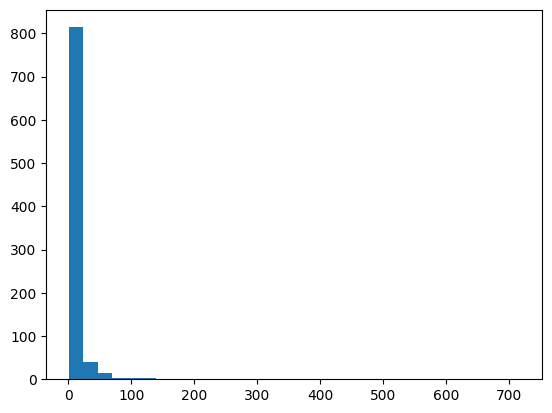

In [4]:
def get_day_pb(date:str,df):
    data = df["price_to_book"][date]
    num_stocks = len(data)
    plt.hist(data,bins=int(np.sqrt(num_stocks)))
    
    return
get_day_pb("2022-01-03",df)

In [5]:
class Benchmark:
    def __init__(self, data: pd.DataFrame): 
        self.price_history: pd.Series
        self.data: pd.DataFrame = data
        self.cur_constituents: List[str] #this is all of current member of the index. 
        self.cur_date: Optional[datetime]
        self.dates: List[datetime]= self.data.index.get_level_values("date").unique().to_list()
        self._i: int = 0 
        self.benchmark_divisor: float = 1
        self.quarterly_recon_dates: List[datetime] = []
        self._get_quarterly_reconst_dates() 
    

    def next_benchmark_price(self) -> float: 
        numerator: float = 0
        # some call to method that checks if the date is a 
        # reconstitution date annd performs the reconsistution. 
        for ticker in self.cur_constituents: 
            key = (self.cur_date,ticker)
            cap_val  = self.data.loc[key]["market_cap"] # type: ignore 
            if np.isnan(cap_val): 
                cap_val = 0.00 
            numerator +=  cap_val 
        next_benchmark = numerator / self.benchmark_divisor
        self.price_history += [next_benchmark]
        self.next_date() #increment the day count forward. 

        return next_benchmark
    

    def _calc_benchmark_divisor(self, start_val: float) -> None: 
        # numerator / start_vale = divisor. 
        return 0.0 

    #========================================================
    #           Date Handling Methods: 
    #========================================================
    
    def _get_quarterly_reconst_dates(self) -> None: 
        """
        Last trading of the months January, April, July, October
        """
        s_dates: pd.Series = pd.Series(self.dates)
        for year in range(self.dates[0].year, self.dates[-1].year + 1):
            for month in [1,4,7,10]:
                year_month_mask = (s_dates.dt.year == year) &  (s_dates.dt.month == month) #type: ignore 
                self.quarterly_recon_dates += [s_dates[year_month_mask].iloc[-1]]
        

    def is_reconstitution_date(self) -> bool:  
        out = False
        annual_recon_dates = [
                             datetime(2021,5,25),
                             datetime(2022,5,24),
                             datetime(2023,5,23),
                             datetime(2024,5,28),
                             datetime(2025,5,27)]
        if self.cur_date in annual_recon_dates: 
            return True
        if self.cur_date in self.quarterly_recon_dates: 
            return True 
        return False 
              

    def next_date(self) -> Optional[datetime]:  
        self.cur_date = self.dates[self._i]
        self._i += 1 
        return self.cur_date

    def quarterly_price_to_book_data(self) -> List[float]:
        dates = self.quarterly_recon_dates
        return self.data["price_to_book"].dropna().loc[dates]

In [6]:
bench = Benchmark(df)
bp = bench.quarterly_recon_dates
bp_quarterly = bench.quarterly_price_to_book_data()

/tmp/ipykernel_297969/3318575477.py:7: FutureWarning: As of SciPy 1.17, users must choose a p-value calculation method by providing the `method` parameter. `method='interpolate'` interpolates the p-value from pre-calculated tables; `method` may also be an instance of `MonteCarloMethod` to approximate the p-value via Monte Carlo simulation. When `method` is specified, the result object will include a `pvalue` attribute and not attributes `critical_value`, `significance_level`, or `fit_result`. Beginning in 1.19.0, these other attributes will no longer be available, and a p-value will always be computed according to one of the available `method` options.
  anderson = stats.anderson(bp_quarterly[i])


 Shapiro pvalue:  2.891256956396279e-53
 Anderson statistic:  253.79768593746485  and critical value @ 5%: 0.751 

 Shapiro pvalue:  4.045960518330526e-50
 Anderson statistic:  200.96545857966134  and critical value @ 5%: 0.751 

 Shapiro pvalue:  1.7671590976881792e-54
 Anderson statistic:  303.6706622600518  and critical value @ 5%: 0.751 

 Shapiro pvalue:  8.014010348776978e-48
 Anderson statistic:  157.23817425996754  and critical value @ 5%: 0.751 

 Shapiro pvalue:  1.0679059176168795e-53
 Anderson statistic:  256.72833584349337  and critical value @ 5%: 0.751 

 Shapiro pvalue:  1.0922979462298378e-54
 Anderson statistic:  320.2869228710224  and critical value @ 5%: 0.751 

 Shapiro pvalue:  5.021944371102247e-53
 Anderson statistic:  248.0532463667803  and critical value @ 5%: 0.751 

 Shapiro pvalue:  2.7176491538953163e-52
 Anderson statistic:  218.33323810846127  and critical value @ 5%: 0.751 

 Shapiro pvalue:  2.673640779410722e-51
 Anderson statistic:  207.7643009674557

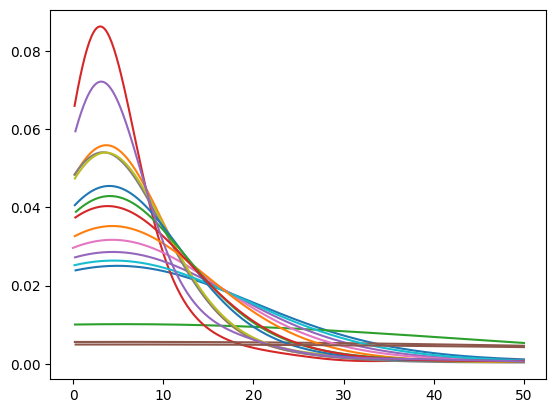

In [8]:
from scipy import stats
for i in bp:
    kde = stats.gaussian_kde(bp_quarterly[i])
    xs = np.linspace(bp_quarterly[i].min(),50,400)
    plt.plot(xs, kde(xs))
    shapiro = stats.shapiro(bp_quarterly[i])
    anderson = stats.anderson(bp_quarterly[i])
    print(" Shapiro pvalue: ",shapiro.pvalue)
    print(" Anderson statistic: ",anderson.statistic," and critical value @ 5%:",anderson.critical_values[2],"\n")